<h1 style="text-align:center;">Лабораторная работа №5</h1>

<h3 style="text-align:center;">Осипов Алексей Б01-204</h3>

**Цель**: для функции, заданной таблично, вычислить значение определённого интеграла методом трапеций, сделать уточнение результата по правилу Рунге. Сравнить уточнённый результат с результатом вычислений по формуле Симпсона. 


В качестве данных я выбрал **вариант д)**
| x     | f(x)    |
|-------|---------|
| 0.0   | 0.000000|
| 0.125 | 0.124670|
| 0.25  | 0.247234|
| 0.375 | 0.364902|
| 0.5   | 0.473112|
| 0.625 | 0.563209|
| 0.75  | 0.616193|
| 0.875 | 0.579699|
| 1.0   | 0.000000|

In [74]:
import numpy as np
import math
import matplotlib.pyplot as plt
import copy

In [16]:
x = [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0]
f = [0.000000, 0.124670, 0.247234, 0.364902, 0.473112, 0.563209, 0.616193, 0.579699, 0.000000]

Буду использовать свой метод Гаусса и сплайн интерполяцию из 3й и 4й лаб

In [19]:
# Вычисление 3й нормы вектора
def norm_3(U):
    r = 0
    for i in range(len(U)):
        r += U[i,0] * U[i,0]
        
    return np.sqrt(r)

# Поменять строки
def swap_rows(A, i, j):
    A[[i, j], :] = A[[j, i], :]

# Поменять столбцы
def swap_columns(A, i, j):
    A[:, [i, j]] = A[:, [j, i]]
    
#Функция для обмена значений
def swap(a,b):
    return b,a
    
# глобальный элемент А
def find_main_el(A, iter):
    size = A.shape[0]
    main_el = A[iter,iter]
    i_main = iter
    j_main = iter

    for i in range(size - iter): 
        for j in range(size - iter):
            if abs(A[i + iter,j + iter]) > abs(main_el):
                i_main = i + iter
                j_main = j + iter
                main_el = A[i_main,j_main]
    return [i_main, j_main]

def Gauss(a, f):
    
    A = copy.deepcopy(a)
    F = copy.deepcopy(f)
    
    size = len(A)  # размеры матрицы 
    
    X = np.arange(size) # Массив, чтобы запомнить порядок при смене строк и столбцов - пригодится в конце
    U  = np.ones((size, 1)) # массив решений
    result = np.ones((size, 1)) # Для ответа

    # Прямой ход
    for iter in range(size): 
        
        main_ind = find_main_el(A,iter) # Rоординаты главного элемента
        main_el = A[main_ind[0], main_ind[1]] # Сам главный элемент
        
        if(main_ind[0] - iter != 0): # Перестановка строк для главного элемента
            swap_rows(A[iter:, iter:], 0, main_ind[0] - iter)
            F[iter] = F[main_ind[0]] + F[iter]
            F[main_ind[0]] = F[iter] - F[main_ind[0]]
            F[iter] = F[iter] - F[main_ind[0]]
            
        if(main_ind[1] - iter != 0): # Перестановка столбцов для главного элемента
            swap_columns(A, iter, main_ind[1])
            # swap(X[iter], X[main_ind[1]])
            X[iter] = X[main_ind[1]] + X[iter]
            X[main_ind[1]] = X[iter] - X[main_ind[1]]
            X[iter] = X[iter] - X[main_ind[1]]
        
        A[iter:, iter:][0] =  A[iter:, iter:][0] / main_el
        F[iter] = F[iter] / main_el
        
        for i in range(size - iter - 1):
            F[iter + i + 1] -= (F[iter]  * A[iter:, iter:][i + 1][0])
            A[iter:, iter:][i + 1] -= (A[iter:, iter:][0] * A[iter:, iter:][i + 1][0])

    # Так как алгоритм не доходит до нижнего углового элемента, делаем его 1
    F[-1] /= A[-1, -1]
    A[size - 1, size - 1] = 1
    
    # Обратный ход
    for i in range(size-1, -1, -1):
        U[i] = F[i]
        for j in range(i + 1, size):
            U[i] -= U[j] * A[i][j]

    for i in range(size):
        result[int(X[i])][0] = U[i][0]

    return result

In [21]:
def spline(x, f):
    h = np.diff(x) # Можно было просто написать 10, т.к. в моём случае шаг одинаковый, но для общего случая так лучше
    
    # Составление матрицы и вектора правых частей для системы
    n = len(x) - 1
    A = np.zeros((n + 1, n + 1))
    B = np.zeros((n + 1, 1))
    
    # Условия на второй производной в краевых точках
    A[0, 0] = 1
    A[n, n] = 1
    
    # Заполнение матрицы для внутренних точек
    for i in range(1, n):
        A[i, i - 1] = h[i - 1]
        A[i, i] = 2 * (h[i - 1] + h[i])
        A[i, i + 1] = h[i]
        B[i] = 3 * ((f[i + 1] - f[i]) / h[i] - (f[i] - f[i - 1]) / h[i - 1])
    
    # Решение системы на коэффициенты c_k
    c = Gauss(A, B)
    
    # Вычисление коэффициентов b_k и d_k
    b = np.zeros(n)
    d = np.zeros(n)
    for i in range(n):
        b[i] = (f[i + 1] - f[i]) / h[i] - h[i] * (2 * c[i][0] + c[i + 1][0]) / 3
        d[i] = (c[i + 1][0] - c[i][0]) / (3 * h[i])
        
    return b, c, d

# Построение сплайна
b, c, d = spline(x, f)
x_fine = np.linspace(x[0], x[-1], 500)
y_fine = np.zeros_like(x_fine)
    
for i in range(len(x)-1):
    mask = (x_fine >= x[i]) & (x_fine <= x[i + 1]) # Переменная mask нужна для того, чтобы понять, лежат ли текущие точки 
    dx = x_fine[mask] - x[i]                           # в данном интервале или нет
    y_fine[mask] = (f[i] + b[i] * dx + c[i] * dx**2 + d[i] * dx**3) #dx - расстояние между текущими точками и левым концом интервала

**1) Метод трапеций + правило Рунге**

In [86]:
h = (x[-1] - x[0]) / 8 # Сделаем равномерную сетку

In [88]:
def trapez(x, f): # Метод трапеций
    n = len(x) - 1
    integral = 0.5 * h * (f[0] + 2 * np.sum(f[1:n]) + f[n])
    return integral

In [90]:
def Runge(I_h, I_2h, p = 2):
    return I_h + (I_h - I_2h) / (2**p - 1)

In [113]:
def trapez_Runge(x, f):
    I_h = trapez(x, f)
    I_2h = 0  # Для уточненного интеграла
    
    b, c, d = spline(x, f)
    
    # Интегрирование с половинным шагом
    for i in range(len(x) - 1):
        x_mid = (x[i] + x[i + 1]) / 2 # Середина интервала
        dx = x_mid - x[i]
        f_mid = f[i] + b[i] * dx + c[i] * dx**2 + d[i] * dx**3  # Используем кубический сплайн
        
        # Метод трапеций на половинном шаге
        I_2h += 0.5 * (x_mid - x[i]) * (f[i] + f_mid)  # Левая половина
        I_2h += 0.5 * (x[i + 1] - x_mid) * (f_mid + f[i + 1])  # Правая половина
    
    # Уточнение интеграла с использованием правила Рунге
    return Runge(I_h, I_2h, p=2)

I_trapez = float(trapez(x, f))
I_trapez_Runge = trapez_Runge(x, f).item()

print("Интеграл методом трапеций:", round(I_trapez, 6))
print("Уточнённый интеграл с помощью правила Рунге: ", round(I_trapez_Runge, 6))


Интеграл методом трапеций: 0.371127
Уточнённый интеграл с помощью правила Рунге:  0.368928


**2) Метод Симпсона**

Мы взяли равномерную сетку и чётное количество интервалов, так что можем использовать метод Симпсона



$$I \approx \sum_{k=0}^{\lfloor n/2 \rfloor} \frac{h_{2k}}{3} \left( f(x_{2k}) + 4f(x_{2k+1}) + f(x_{2k+2}) \right)$$

In [111]:
def Simpson(x, f):
    n = len(x) - 1
    if n % 2 == 1:
        raise ValueError("Метод Симпсона требует четное количество отрезков.")
    integral = f[0] + f[-1]  # Начальные условия
    
    for i in range(1, n, 2):
        integral += 4 * f[i]
    for i in range(2, n-1, 2):
        integral += 2 * f[i]
    
    integral *= h / 3
    return integral

I_Simpson = Simpson(x, f)
print("Значение интеграла методом Симпсона:", round(I_Simpson, 6))

Значение интеграла методом Симпсона: 0.383458


Теперь методом Симпсона попробуем посчитать интеграл какой-нибудь быстро осциллирующей функции, например $ f(x) = \sin(100x) \cdot e^{-x}$

In [158]:
def function(x, k):
    return np.exp(-x) * np.sin(k * x)

def simpson_sin(x, f, k):
    n = len(x) - 1 
    if n % 2 == 1:
       # Уменьшаем количество точек на 1, чтобы отрезков было четное количество
        x = x[:-1]
        n -= 1
    
    h = (x[-1] - x[0]) / n  # Шаг сетки
    integral = f(x[0], k) + f(x[-1], k)  # Начальные условия
    
    # Суммирование четных и нечетных индексов
    for i in range(1, n, 2):
        integral += 4 * f(x[i], k)
    for i in range(2, n-1, 2):
        integral += 2 * f(x[i], k)
    
    integral *= h / 3
    return integral

k = 100
x = np.linspace(0, 1, 5000)  # Сетка значений от 0 до 1

# Вычисление численного интеграла
I_simpson_sin = simpson_sin(x, function, k)
print("Значение интеграла методом Симпсона:", round(I_simpson_sin, 6))

Значение интеграла методом Симпсона: 0.006884


Для сравнения, вот результат интеграла для такой же функции в онлайн калькуляторе

![alt text](lab5_1.jpg)

Ради эксперимента, построю график зависимости значения интеграла от количества точек, разбивающих отрезок $[0,1]$

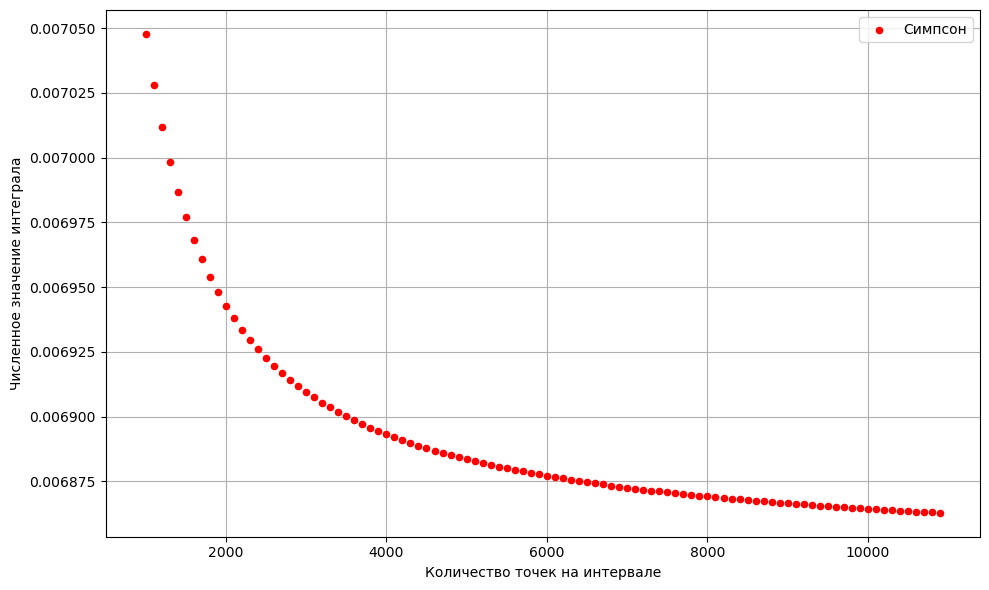

In [209]:
x_vals = []
I = []
setka = 1000
for i in range(100):
    x = np.linspace(0, 1, setka)
    I_simpson_sin = simpson_sin(x, function, k)
    x_vals.append(setka)
    I.append(I_simpson_sin)
    setka += 100
    i += 1

plt.figure(figsize = [10,6])

plt.scatter(x_vals, I, s = 20, label = "Симпсон", color = "red", zorder=3)
plt.xlabel('Количество точек на интервале')
plt.ylabel('Численное значение интеграла')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()